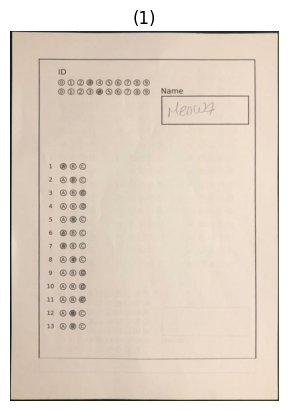

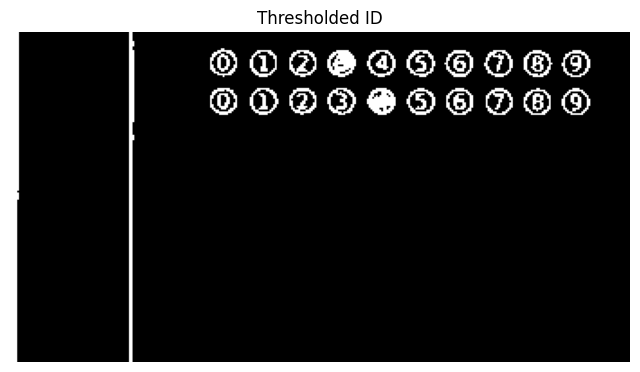

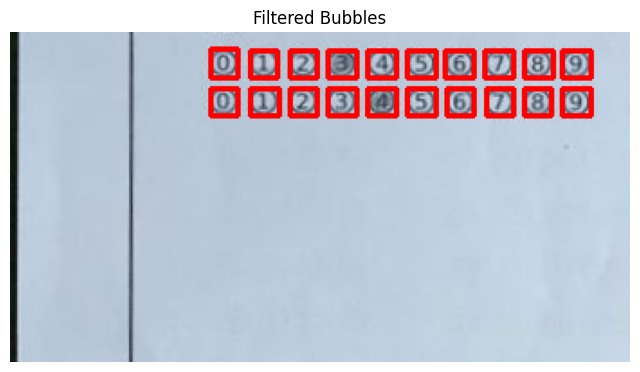

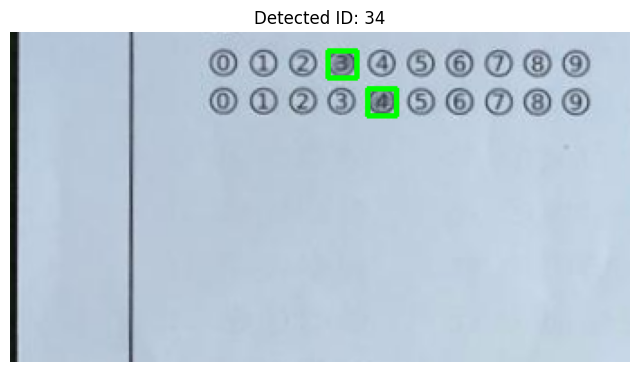

Detected ID: 34


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from paperExtraction import *
from utils import *

def detectID(idImage):
    bubbleMinSize = 10
    aspectRatioTolerance = 0.2
    grayScale = cv.cvtColor(idImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(grayScale, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    show_image(binary, "Thresholded ID")

    allContours = cv.findContours(binary.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    allContours = imutils.grab_contours(allContours)

    bubbleContours = []
    testImage = idImage.copy()
    for contour in allContours:
        x, y, width, height = cv.boundingRect(contour)
        aspectRatio = width / float(height)
        if width >= bubbleMinSize and height >= bubbleMinSize and abs(aspectRatio - 1) <= aspectRatioTolerance:
            bubbleContours.append(contour)
            cv.rectangle(testImage, (x, y), (x + width,y + height), (0, 0, 255), 2)
    show_image(testImage, "Filtered Bubbles")

    if not bubbleContours:
        return ""

    # Sort top-to-bottom
    bubbleContours = contours.sort_contours(bubbleContours, method = "top-to-bottom")[0]

    # Split into rows
    rows = []
    currentRow = []
    rowHeightTolerance = 10
    for contour in bubbleContours:
        x, y, width, height = cv.boundingRect(contour)
        if not currentRow:
            currentRow = [contour]
            currentRowY = y
        elif abs(y - currentRowY) <= rowHeightTolerance:
            currentRow.append(contour)
        else:
            rows.append(sorted(currentRow, key = lambda r: cv.boundingRect(r)[0]))
            currentRow = [contour]
            currentRowY = y
    if currentRow:
        rows.append(sorted(currentRow, key = lambda r: cv.boundingRect(r)[0]))

    # Detect filled bubble in each row
    id_number = ""
    detectedBubblesImage = idImage.copy()
    for row in rows:
        maxFilled = 0
        filledChoice = None
        for i, contour in enumerate(row):
            mask = np.zeros(binary.shape, dtype="uint8")
            cv.drawContours(mask, [contour], -1, 255, -1)
            filledPixels = cv.countNonZero(cv.bitwise_and(binary, binary, mask=mask))
            if filledPixels > maxFilled:
                maxFilled = filledPixels
                filledChoice = i
        if filledChoice is not None:
            id_number += str(filledChoice)
            x, y, width, height = cv.boundingRect(row[filledChoice])
            cv.rectangle(detectedBubblesImage, (x, y), (x + width, y + height), (0, 255, 0), 2)

    show_image(detectedBubblesImage, f"Detected ID: {id_number}")
    return id_number

imagePath = "../data/images/1.jpg"
paper = extractPaper(imagePath)
show_images([paper])
height, width, channels = paper.shape

idImage = paper[int(0.12*height):height//3, :5*width//9, :]

studentID = detectID(idImage)
print("Detected ID:", studentID)
